In [1]:
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

C:\Users\rsorokin\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\rsorokin\Anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [15]:
import shutil

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

In [3]:
import os
from pathlib import Path

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [44]:
# читаем датасет
data_df = pd.read_csv("../train_dataset_train/train.csv")

Обучающей выборки  543
Тестовой выборки  225


<AxesSubplot:xlabel='class', ylabel='count'>

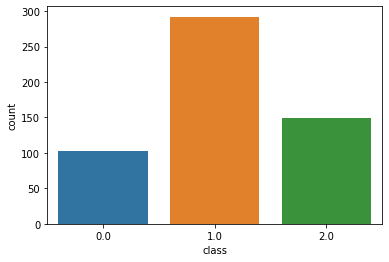

In [45]:
from os import listdir

print("Обучающей выборки " ,len(listdir("../train_dataset_train/train")))
print("Тестовой выборки " ,len(listdir("../test_dataset_test")))


import seaborn as sns
import warnings
 
warnings.simplefilter('ignore')
sns.countplot(x = "class" , data  = data_df)

In [46]:
data_df['class'].value_counts(normalize=True)

1.0    0.537753
2.0    0.274401
0.0    0.187845
Name: class, dtype: float64

In [47]:
data_df['class'].value_counts()

1.0    292
2.0    149
0.0    102
Name: class, dtype: int64

In [48]:
dpi = 100

In [49]:
# переразметим все
bads_list = {
    '220303100248_43538bd76cef189b146930c939c79643.jpg': 2,
    '220306063056_28f4148f4525050e92a5eec4c6b8c233.jpg': 2,
    '220307012903_c2e25c71975244587fb02517aec28abb.jpg': 2,
    '220307023015_d7805fde0aeda728f0136ec7482cc43f.jpg': 2,
    '220307023034_9d7ebe271649a6ebbc3494c026126869.jpg': 2,
    '220307023255_998d453b3382de234da4e1239b8e36e8.jpg': 2,
    '220307024716_902e232dfe9c5ac55643703abcbf1d11.jpg': 2,
    '220307123436_a755745087e8d1f6efb7dde875b3f1be.jpg': 2,
    '220308020735_cea2a44d3ec96fa3d36bae829d63b11e.jpg': 2,
    '220308020750_05d4f485efad771de30f3e727694722a.jpg': 2,
    '220307021153_7377b7a46d03d4a1ccc04ea66ac77150.jpg':1,
    '220307021411_79d767ce528d22b1a5c883473c9a078f.jpg':1,
    '220307023940_f1c6e2ecdfb8557166546183c11c5eaa.jpg':1,
    '220307023943_8bffc92c4f2c2f7a8b9d3400446a48c5.jpg':1,
    '220307024146_b8a7a4d768c4e710b5b5f874b6099dbc.jpg':1,
    '220307024828_7b3e78fd1789a8c474db8346747a0d0d.jpg':1,
    '220307025438_bcb8831f5a1aba7e89830d66a8cfc83a.jpg':1,
    '220307025439_fdcf8babf0f0a876052ce64556e16141.jpg':1,
    '220307030904_b253c43b3f77dcb1cdff52c914f91f4e.jpg':1,
    '220307030931_4baa51f5a816e728f78329ba24b5bf3a.jpg':1,
    '220307032433_3e4a73bc6393a5753ca1e0746cb05101.jpg':1,
    '220307033323_00a172d26fe64536ba7a3ca7bbae7bad.jpg':1,
    '220307034130_4a60f420af65f5979fcfaea0f31dcc71.jpg':1,
    '220307082216_0334b4f0693f5de2fff068503919cb86.jpg':1,
    '220307082227_0042c81cac5dc917687d26d3de8acfd2.jpg':1,
    '220307135416_276e578f15a59662a23ce7c5aa62d278.jpg':1
}

In [50]:
data_df_clear = data_df.copy()
for name in bads_list.keys():
    data_df_clear.loc[data_df_clear['ID_img']==name, 'class'] = bads_list[name]

In [51]:
data_df[data_df['ID_img']==name]['class']

234    2.0
Name: class, dtype: float64

In [52]:
data_df_clear[data_df_clear['ID_img']==name]['class']

234    1.0
Name: class, dtype: float64

In [55]:
data_df_clear.to_csv('../train_dataset_train/train_clear.csv', index=False)

# Готовим датасет для обучения

## Dataset all balanced

In [217]:
data_df = pd.concat(
    [
        pd.read_csv("../train_add_class_0/train.csv"),
        pd.read_csv("../train_add_class_1//train.csv"),
        pd.read_csv("../train_add_3_class_1/train.csv")
    ]
)

In [219]:
data_df.to_csv('../prepare_datasets/data_add_all_balanced/train_add.csv', index=False)

In [220]:
data_df_all = pd.concat(
    [data_df, pd.read_csv('../prepare_datasets/data_add_all_balanced/train_clear.csv')],
)

In [221]:
data_df_all.to_csv('../prepare_datasets/data_add_all_balanced/train_all.csv', index=False)

<AxesSubplot:xlabel='class', ylabel='count'>

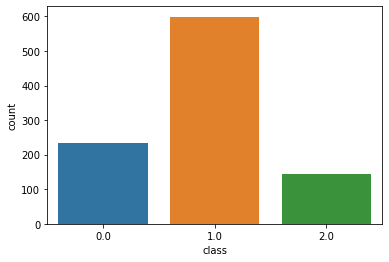

In [225]:
sns.countplot(x = "class" , data  = data_df_all)

In [226]:
data_df_all['class'].value_counts(normalize=True)

1.0    0.614359
0.0    0.238974
2.0    0.146667
Name: class, dtype: float64

In [227]:
need_to_add = data_df_all['class'].value_counts().max() - data_df_all['class'].value_counts()
need_to_add#.reset_index()

1.0      0
0.0    366
2.0    456
Name: class, dtype: int64

In [230]:
need_class_0 = 366
need_class_2 = 456

In [231]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)    

In [232]:
data_df[data_df['class']==2]

,ID_img,class


In [233]:
image0 = cv2.imread('../train_dataset_train/train/220307030925_8cd419dd6ce8c72f66e2fd62d0d9eacf.jpg')
image0 = cv2.cvtColor(image0, cv2.COLOR_BGR2RGB)

image1 = cv2.imread(f"{'../train_dataset_train/train/'}/220301091714_6a066f59c206a24a740589ab1dda00a9.jpg")
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

image2 = cv2.imread(f"{'../train_dataset_train/train/'}/220307030904_b253c43b3f77dcb1cdff52c914f91f4e.jpg")
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

### добавть без мусорок, добавить дубли с флипам и кропами (добить до 1ого класса)

In [236]:
need_class_0 = 366
need_class_2 = 456

In [237]:
zero_class_imgs = data_df_all[data_df_all['class']==0]['ID_img']
first_class_imgs = data_df_all[data_df_all['class']==1]['ID_img']
second_class_imgs = data_df_all[data_df_all['class']==2]['ID_img']

In [241]:
zero_class_imgs.shape

(233,)

In [238]:
need_class_0

366

In [239]:
need_class_2

456

In [242]:
transform_add_zero_class = A.Compose(
    [
        A.HorizontalFlip(p=0.8),
        A.Rotate(limit=20, p=0.8),
#         A.RandomCrop(512, 512),
        A.RandomResizedCrop(512, 512, scale=(0.2, 1.0)),
    ]
)

In [243]:
need_class_0

366

In [272]:
np.random.seed(42)
img_to_trasnfor = np.random.choice(zero_class_imgs, size=need_class_0, replace=True)
img_to_trasnfor[:3]

array(['0_3102.jpg', '220307023443_9d9db6e5ae45f66adc911ca994ff1265.jpg',
       '0_3092.jpg'], dtype=object)

In [273]:
for i in tqdm(img_to_trasnfor):
    solt = np.random.randint(0, 1000)
    destination_1 = f"../prepare_datasets/data_add_all_balanced/all/{i}"
    destination_2 = f"../prepare_datasets/data_add_all_balanced/train_add/{i.split('.')[0] + str(solt) + '_zero_crop.jpg'}"
    image = cv2.imread(destination_1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if image.shape[0] < 512 or image.shape[1] < 512:
        continue
    else:
        transformed = transform_add_zero_class(image=image)
        cv2.imwrite(destination_2, cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR))


100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [00:11<00:00, 32.78it/s]


###  Из хороших сделать 150 испорченных и добавить. Затем полученные 300 плохих дополнительно кропать и флипаьб до 1ого класса

In [338]:
transform_add_blur = A.Compose(
    [
        A.RandomFog(fog_coef_lower=1, fog_coef_upper=1, alpha_coef=0.05, p=0.3),
        A.MotionBlur(blur_limit=(180,210), always_apply=True), 
        A.Blur(blur_limit=(20,35), p=1),
        A.RandomBrightnessContrast(
            brightness_limit=[-0.7, -0.3], 
            contrast_limit=0.1,
            brightness_by_max=True, p=0.13
        )
    ]
)

In [363]:
# готовмим 150 плохих фоток
np.random.seed(42)
img_to_trasnfor_blur_0 = np.random.choice(zero_class_imgs, size=80, replace=True)
img_to_trasnfor_blur_1 = np.random.choice(first_class_imgs, size=140, replace=True)
img_to_trasnfor_blur = np.concatenate((img_to_trasnfor_blur_0, img_to_trasnfor_blur_1))

In [364]:
for i in tqdm(img_to_trasnfor_blur):
    solt = np.random.randint(0, 1000)
    destination_1 = f"../prepare_datasets/data_add_all_balanced/all/{i}"
    destination_2 = f"../prepare_datasets/data_add_all_balanced/train_add/{'2_' + i.split('.')[0] + '_' + str(solt) + '_blur.jpg'}"
    image = cv2.imread(destination_1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transformed = transform_add_blur(image=image)
    cv2.imwrite(destination_2, cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR))

100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [08:44<00:00,  2.38s/it]


#### Затем полученные 300 плохих дополнительно кропать и флипаь до 1ого класса

In [365]:
img_classes = {i: i.split('_')[0] for i in os.listdir('../prepare_datasets/data_add_all_balanced/train_add/')}

In [366]:
blur_imgs_1 = [k for k, v in img_classes.items() if v == '2']

In [367]:
len(blur_imgs_1)

220

In [368]:
# готовмим 150 плохих фоток
np.random.seed(42)
blur_imgs_to_trasnfor = np.random.choice(blur_imgs_1, size=220, replace=False)

In [369]:
transform_add_second_class = A.Compose(
    [
        A.HorizontalFlip(p=0.8),
        A.Rotate(limit=20, p=0.8),
#         A.RandomCrop(512, 512),
        A.RandomResizedCrop(512, 512, scale=(0.2, 1.0), always_apply=True),
    ]
)

In [370]:
for i in tqdm(blur_imgs_to_trasnfor):
    solt = np.random.randint(0, 2000)
    destination_1 = f"../prepare_datasets/data_add_all_balanced/train_add/{i}"
    destination_2 = f"../prepare_datasets/data_add_all_balanced/train_add/{i.split('.')[0] +'_' + str(solt) + '_blur_crop.jpg'}"
    image = cv2.imread(destination_1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if image.shape[0] < 512 or image.shape[1] < 512:
        continue
    else:
        transformed = transform_add_second_class(image=image)
        cv2.imwrite(destination_2, cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR))


100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:29<00:00,  7.44it/s]


In [371]:
# сохраняем разметку

In [372]:
cur_pth = Path('..')
path_to_img = 'prepare_datasets/data_add_all_balanced'
dir_name = 'train_add'
img_format = '.jpg'

In [373]:
i.split('.')[0].split('_')

['2', '1', '4123', '322', 'blur']

In [374]:
'2' in i.split('.')[0].split('_')

True

In [375]:
def foo(x):
    if 'blur' in x.split('.')[0].split('_'):
        return 2

    if 'zero' in x.split('.')[0].split('_'):
        return 0
    
    if '1' in x.split('.')[0].split('_'):
        return 1
    
    if '0' in x.split('.')[0].split('_'):
        return 0

In [376]:
df_new = pd.DataFrame(
    [[i, foo(i)] for i in os.listdir(cur_pth/path_to_img/dir_name)],    
    columns=['ID_img', 'class']
).dropna()

In [377]:
df_new

,ID_img,class
0,0_3000.jpg,0
1,0_3000313_zero_crop.jpg,0
2,0_3001.jpg,0
3,0_3001431_zero_crop.jpg,0
4,0_3001606_zero_crop.jpg,0
...,...,...
1157,2_220307090137_06b24305e9852f3373fa26e0231ea90...,2
1158,2_220307090248_c0b2eaf82c3da865fd9a88acfcd8c12...,2
1159,2_220307090527_9d1251afcc1024f55fcf087280e99ee...,2
1160,2_220307090527_9d1251afcc1024f55fcf087280e99ee...,2


In [378]:
data_df_train = pd.read_csv("../train_dataset_train/train.csv")

In [385]:
data_df_train['class'].value_counts(normalize=True)

1.0    0.537753
2.0    0.274401
0.0    0.187845
Name: class, dtype: float64

<AxesSubplot:xlabel='class', ylabel='count'>

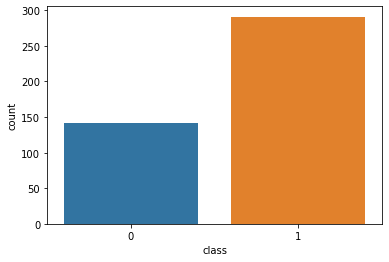

In [379]:
sns.countplot(x = "class" , data  = data_df)

<AxesSubplot:xlabel='class', ylabel='count'>

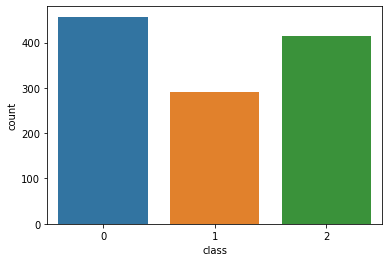

In [380]:
sns.countplot(x = "class" , data  = df_new)

<AxesSubplot:xlabel='class', ylabel='count'>

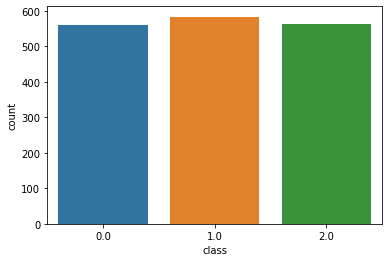

In [381]:
sns.countplot(x = "class" , data  = pd.concat([data_df_train, df_new]))

In [382]:
df_new.to_csv('../prepare_datasets/data_add_all_balanced/train_add.csv', index=False)

In [383]:
pd.concat([data_df_train, df_new])#.to_csv('../prepare_datasets/data_add_all_balanced/train_all_add.csv', index=False)

,ID_img,class
0,220301124100_d3815192b7a85e54f935936bbe09496f.jpg,0.0
1,220301124101_c919e95934b3df93a6149764a498b11f.jpg,0.0
2,220301124110_69dcd5eb441c4df666dfedde7ac47fc6.jpg,0.0
3,220301124113_a102c632672df1b5d1e0b7a0fe7360d2.jpg,0.0
4,220301124127_d28e5d63f63b1306b75db49eecbcd3be.jpg,0.0
...,...,...
1157,2_220307090137_06b24305e9852f3373fa26e0231ea90...,2.0
1158,2_220307090248_c0b2eaf82c3da865fd9a88acfcd8c12...,2.0
1159,2_220307090527_9d1251afcc1024f55fcf087280e99ee...,2.0
1160,2_220307090527_9d1251afcc1024f55fcf087280e99ee...,2.0


In [384]:
pd.concat([data_df_train, df_new]).to_csv('../prepare_datasets/data_add_all_balanced/train_all_add.csv', index=False)